In [1]:
import torch
import numpy as np
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor
from nnunetv2.utilities.get_network_from_plans import get_network_from_plans
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
import json
from pathlib import Path

# Define root directory and dataset paths
ROOT_DIR = Path("/nfs/erelab001/shared/Computational_Group/Naravich")
datasets = ROOT_DIR / "datasets" / "nnUNet_Datasets"

plans_file = datasets / "nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json"
dataset_file = datasets / "nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/dataset.json"
with open(dataset_file) as f:
    dataset_json = json.load(f)

# Define model path
model_path = None # No pretrained?
# model_path = datasets / "nnUNet_results/Dataset300_Lumen_and_Wall_OCT/nnUNetTrainer__nnUNetPreprocessPlans__3d_fullres"
# model checkpoint is in fold_all/checkpoint_best.pth

# Define images path
image_path = datasets / "nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans_3d_fullres"

In [3]:
import torch
import numpy as np
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor
from nnunetv2.utilities.get_network_from_plans import get_network_from_plans
from nnunetv2.utilities.plans_handling.plans_handler import PlansManager, ConfigurationManager
from nnunetv2.utilities.label_handling.label_handling import LabelManager, determine_num_input_channels
import matplotlib.pyplot as plt
from pathlib import Path
import json

def initialize_untrained_predictor(predictor, plans_file):
    """Initialize predictor with an untrained model based on plans file.
    
    Args:
        predictor: nnUNetPredictor instance
        plans_file: Path to the plans.json file
    """
    # Load network from plans
    plans_file = Path(plans_file)
    if not plans_file.exists():
        raise FileNotFoundError(f"Plans file not found: {plans_file}")
    
    # Load and parse plans
    with open(plans_file) as f:
        plans = json.load(f)
    
    # Initialize managers
    plans_manager = PlansManager(plans_file)
    configuration = "3d_32x160x128_b10"
    if configuration not in plans['configurations']:
        configuration = list(plans['configurations'].keys())[0]
    
    configuration_manager = plans_manager.get_configuration(configuration)
    label_manager = plans_manager.get_label_manager(dataset_json)
    num_input_channels = determine_num_input_channels(plans_manager, configuration_manager,dataset_json)
    # Get network parameters from configuration manager
    network = get_network_from_plans(
        arch_class_name=configuration_manager.network_arch_class_name,
        arch_kwargs=configuration_manager.network_arch_init_kwargs,
        arch_kwargs_req_import=configuration_manager.network_arch_init_kwargs_req_import,
        input_channels=num_input_channels,
        output_channels=label_manager.num_segmentation_heads,
        allow_init=True,
        deep_supervision=True
    )
    network.to(predictor.device)
    
    # Initialize predictor with untrained network
    predictor.network = network
    predictor.plans_manager = plans_manager
    predictor.configuration_manager = configuration_manager
    predictor.label_manager = label_manager
    predictor.plans = plans
    predictor.configuration_name = configuration
    
    print(f"Initialized untrained network from {plans_file}")
    print(f"Using configuration: {configuration}")
    print(f"Architecture: {configuration_manager.network_arch_class_name}")
    print(f"Input channels: {num_input_channels}, Output channels: {label_manager.num_segmentation_heads}")
    return predictor

# Initialize predictor
predictor = nnUNetPredictor(
    tile_step_size=0.5,
    use_gaussian=True,
    use_mirroring=True,
    perform_everything_on_device=True,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# nnUNet embedding visualization (PCA + UMAP)

This notebook adds utilities to extract intermediate embeddings (feature maps) from a trained nnUNet model and visualize them using PCA and UMAP.

How to use:
- Ensure `predictor`, `model_path`, and `image_path` variables are set (they are defined above in this notebook).
- Run the imports/install cell (Cell N+1).
- Run the helper functions cell (Cell N+2).
- Update the example run cell with a case filename if necessary and run it (Cell N+3).

Notes:
- The extraction uses a forward hook on a selected module (by default the last encoder stage / bottleneck). You can change the `target_module_name` in the example to capture other layers.
- We sample voxels for UMAP to keep computation light; increase `n_samples` if you want more points.
- If your data uses different key names (e.g., `.npz` with `data`/`arr_0`), adjust the loading step accordingly.

In [4]:
# Imports and installs (will try to install umap-learn if missing)
import sys
import subprocess
import importlib

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.decomposition import PCA

# Try import umap, install if missing
try:
    import umap
except Exception:
    print('umap not found, attempting to install umap-learn...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'umap-learn'])
    importlib.invalidate_caches()
    import umap

print('torch:', torch.__version__)
print('umap:', umap.__version__)
print('sklearn:', importlib.import_module('sklearn').__version__)

# helper - device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch: 2.5.1
umap: 0.5.9.post2
sklearn: 1.7.2
Device: cuda


In [5]:
# Helper functions: load model into predictor, extract activations via hook, flatten embeddings
from typing import Optional, Tuple, Dict

def initialize_predictor_from_folder(predictor: nnUNetPredictor, model_folder: Path, checkpoint_name: Optional[str] = None):
    """Try to initialize the predictor from a trained model folder.
    Falls back to searching for checkpoint files if `initialize_from_trained_model_folder` is not available.
    """
    model_folder = Path(model_folder)
    # Prefer built-in initializer if available
    try:
        predictor.initialize_from_trained_model_folder(str(model_folder), use_folds="all", checkpoint_name=checkpoint_name)
        print('Initialized predictor via initialize_from_trained_model_folder')
        return
    except Exception as e:
        print('initialize_from_trained_model_folder not available or failed, trying to load checkpoint directly:', e)

    # Fallback: find a checkpoint file
    candidates = list(model_folder.rglob('checkpoint*.pth')) + list(model_folder.rglob('*.pth'))
    if not candidates:
        raise FileNotFoundError(f'No checkpoint found under {model_folder}')
    # choose the most recent candidate
    ckpt = sorted(candidates)[-1]
    ckpt = str(ckpt)
    print('Loading checkpoint:', ckpt)
    state = torch.load(ckpt, map_location=DEVICE)
    # handle different save formats
    if isinstance(state, dict) and 'state_dict' in state:
        sd = state['state_dict']
    elif isinstance(state, dict) and any(k.startswith('network') or k.startswith('model') for k in state.keys()):
        # try to find direct network dict
        sd = None
        for k in ['network', 'model', 'state_dict']:
            if k in state:
                sd = state[k]
                break
        if sd is None:
            # maybe the state is the state_dict itself
            sd = state
    else:
        sd = state
    try:
        predictor.network.load_state_dict(sd)
    except Exception as e:
        print('Failed to load state_dict directly into predictor.network:', e)
        # Try to handle prefixed keys
        new_sd = {}
        for k,v in sd.items():
            new_key = k
            if k.startswith('module.'):
                new_key = k[len('module.'):]
            new_sd[new_key] = v
        predictor.network.load_state_dict(new_sd)
    predictor.network.to(DEVICE)
    predictor.device = DEVICE
    predictor.network.eval()
    print('Checkpoint loaded and network set to eval on', DEVICE)


def extract_activations(predictor, input_tensor: torch.Tensor, target_module_name: Optional[str] = None) -> Tuple[Dict[str, torch.Tensor], torch.Tensor]:
    """Run forward and capture activations from the specified module.

    Returns (activations, output_prediction)
    - activations: dict name -> tensor (B,C,...) on CPU
    - output_prediction: raw network output (if returned by forward)
    """
    net = predictor.network
    net = net.to(DEVICE)
    activations = {}
    hooks = []

    # Decide which module to hook
    def find_module_by_name(root, name):
        # name may be like 'encoder.stages.4' or simple 'encoder'
        if not name:
            return None
        parts = name.split('.')
        cur = root
        try:
            for p in parts:
                if p.isdigit():
                    cur = cur[int(p)]
                else:
                    cur = getattr(cur, p)
            return cur
        except Exception:
            return None

    if target_module_name is None:
        # attempt to find a bottleneck or last encoder stage
        candidates = []
        if hasattr(net, 'encoder'):
            enc = net.encoder
            # common attribute names
            if hasattr(enc, 'stages'):
                try:
                    candidates.append(enc.stages[-1])
                    target_module = enc.stages[-1]
                    target_name = 'encoder.stages.-1'
                except Exception:
                    target_module = enc
                    target_name = 'encoder'
            else:
                target_module = enc
                target_name = 'encoder'
        else:
            # fallback to entire network
            target_module = net
            target_name = 'network'
    else:
        m = find_module_by_name(net, target_module_name)
        if m is None:
            raise ValueError(f'Could not find module by name {target_module_name}')
        target_module = m
        target_name = target_module_name

    # register forward hook
    def hook_fn(module, inp, out):
        # detach and move to cpu
        activations[target_name] = out.detach().cpu()

    hooks.append(target_module.register_forward_hook(hook_fn))

    # run forward
    was_training = net.training
    net.eval()
    with torch.no_grad():
        x = input_tensor.to(DEVICE).float()
        # ensure batch dimension
        if x.ndim == len(net.forward.__annotations__.get('return', [])):
            pass
        # we call the raw network - predictor may have helper wrappers but direct forward usually works
        try:
            out = net(x)
        except Exception as e:
            # If forward signature expects (x, do_mirroring, ...), try predictor.run_network
            try:
                out = predictor.network(x)
            except Exception as e2:
                raise RuntimeError('Failed to run network forward: ' + str(e2))

    # remove hooks
    for h in hooks:
        h.remove()
    if was_training:
        net.train()

    return activations, out


def flatten_activations(activation: torch.Tensor) -> np.ndarray:
    """Convert activation tensor (B,C,H,W,(D)) to (N_voxels, C) numpy array (for first batch only)."""
    # activation shape [B, C, *spatial]
    act = activation.cpu().numpy()
    B, C = act.shape[:2]
    spatial = act.shape[2:]
    N = int(np.prod(spatial))
    # take first batch
    arr = act[0].reshape(C, -1).T  # (N, C)
    return arr, spatial

print('Helper functions defined: initialize_predictor_from_folder, extract_activations, flatten_activations')

Helper functions defined: initialize_predictor_from_folder, extract_activations, flatten_activations


In [ ]:
# Example: end-to-end extraction -> PCA -> UMAP -> visualize
# Assumes `model_path`, `image_path`, and `predictor` exist in the notebook scope.

from random import Random
import matplotlib

# Utility to find a case file in image_path (supports .npz, .npy, .nii.gz)
def find_case_file(image_dir: Path):
    for ext in ('*.npz', '*.npy', '*.nii.gz', '*.nii'):
        files = list(Path(image_dir).rglob(ext))
        if files:
            return files[0]
    raise FileNotFoundError(f'No case file found under {image_dir}')

# Load model (safe wrapper)
try:
    initialize_predictor_from_folder(predictor, model_path, checkpoint_name='checkpoint_best.pth')
except Exception as e:
    initialize_untrained_predictor(predictor, plans_file)
    print("Initialized untrained predictor. As the model path is not provided or invalid.")
    # print('initialize_predictor_from_folder failed; ensure predictor and model_path are correct:', e)

# Pick a case file
case_file = find_case_file(image_path)
print('Using case file:', case_file)

# Load the case - try multiple key names
if case_file.suffix == '.npz':
    arr = np.load(case_file)
    # common keys: 'data', 'x', 'arr_0'
    for k in ('data','x','arr_0','image','images'):
        if k in arr:
            img = arr[k]
            break
    else:
        # take the first array
        img = arr[list(arr.files)[0]]
elif case_file.suffix == '.npy':
    img = np.load(case_file)
else:
    # for .nii or .nii.gz use nibabel if available
    try:
        import nibabel as nib
    except Exception:
        raise RuntimeError('To load NiFTI files please install nibabel (pip install nibabel)')
    img = nib.load(str(case_file)).get_fdata()


Initialized untrained network from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json
Using configuration: 3d_32x160x128_b10
Architecture: dynamic_network_architectures.architectures.unet.PlainConvUNet
Input channels: 1, Output channels: 2
initialize_predictor_from_folder failed; ensure predictor and model_path are correct: expected str, bytes or os.PathLike object, not NoneType
Using case file: /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans_3d_fullres/101-019.npz


## Interactive patch selection

Use the cell below to set a patch size (we'll use 32 x 160 x 128 by default), visualize a patch extracted at an offset you provide, and then run the patch through the network to extract embeddings. The loop lets you adjust the offset interactively until you accept the patch. No stitching is done — this only runs a single patch through the model (good for GPU and quick inspection).

## Feature Extraction

In [7]:
%matplotlib inline


In [8]:
# Capture and visualize multiple stages' activations
# Usage example:
#   visualize_stages_for_patch(patch, module_names=None, channels_per_stage=3)
# where patch is a numpy array (C, D, H, W) or the same `input_tensor` shape used before.

from typing import List


def find_module_by_name(root, name: str):
    if not name:
        return None
    cur = root
    for p in name.split('.'):
        if p.isdigit():
            cur = cur[int(p)]
        else:
            cur = getattr(cur, p)
    return cur


def default_stage_names_for(net, max_stages=4) -> List[str]:
    # choose last `max_stages` encoder stages if available
    if hasattr(net, 'encoder') and hasattr(net.encoder, 'stages'):
        n = len(net.encoder.stages)
        idxs = list(range(max(0, n - max_stages), n))
        return [f'encoder.stages.{i}' for i in idxs]
    # fallback heuristics
    candidates = []
    if hasattr(net, 'encoder'):
        candidates.append('encoder')
    candidates.append('network')
    return candidates[:max_stages]


def capture_activations_multiple(predictor, input_tensor: torch.Tensor, module_names: List[str]):
    """Run forward and capture activations from multiple modules. Returns dict name->tensor (on CPU) and network output."""
    net = predictor.network
    net.to(DEVICE)
    net.eval()
    activations = {}
    handles = []

    def make_hook(name):
        def hook(module, inp, out):
            # store on CPU to avoid holding GPU memory across stages
            activations[name] = out.detach().cpu()
        return hook

    for name in module_names:
        m = find_module_by_name(net, name)
        if m is None:
            raise ValueError(f'Could not resolve module {name}')
        handles.append(m.register_forward_hook(make_hook(name)))

    with torch.no_grad():
        x = input_tensor.to(DEVICE).float()
        out = net(x)

    for h in handles:
        h.remove()

    return activations, out


def visualize_activations_grid(activations: dict, channels_per_stage: int = 3, cmap='viridis'):
    """Plot a grid: one row per activation (module), columns are feature channels (first channels_per_stage channels).
    Each cell shows the central depth slice for 3D activations (or the 2D activation if 4D).
    """
    names = list(activations.keys())
    nrows = len(names)
    # determine number of columns as min available channels and requested
    first_act = next(iter(activations.values()))
    if first_act.ndim < 3:
        raise RuntimeError('Activation tensors have unexpected rank: ' + str(first_act.shape))

    # For each activation determine channels
    channels_per_stage = int(channels_per_stage)
    fig_cols = channels_per_stage
    fig, axes = plt.subplots(nrows, fig_cols, figsize=(4*fig_cols, 4*nrows))
    if nrows == 1:
        axes = np.atleast_2d(axes)
    axes = np.array(axes).reshape(nrows, fig_cols)

    for i, name in enumerate(names):
        act = activations[name].numpy()  # [B, C, (D,), H, W] or [B, C, H, W]
        B, C = act.shape[0], act.shape[1]
        spatial = act.shape[2:]
        # choose channels to display
        nshow = min(C, channels_per_stage)
        for j in range(fig_cols):
            ax = axes[i, j]
            ax.axis('off')
            if j < nshow:
                ch = j
                if len(spatial) == 3:
                    # 3D activation: (D,H,W)
                    mid = spatial[0] // 2
                    img = act[0, ch, mid]
                elif len(spatial) == 2:
                    img = act[0, ch]
                else:
                    # higher dims - try to collapse
                    img = act[0, ch].squeeze()
                im = ax.imshow(img, cmap=cmap)
                ax.set_title(f'{name}\nch {ch} shape {img.shape}')
                fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            else:
                ax.set_visible(False)
    plt.tight_layout()
    plt.show()


def visualize_stages_for_patch(patch_np: np.ndarray, module_names: List[str] = None, channels_per_stage: int = 3):
    """Convenience wrapper: given patch numpy (C, D, H, W) or (1,C,D,H,W), capture activations and visualize grid."""
    # normalize patch shape to (B=1,C,...)
    x = patch_np
    if x.ndim == 4:
        x = np.expand_dims(x, 0)
    elif x.ndim == 5 and x.shape[0] != 1:
        # assume already batched >1; take first
        x = x[0:1]
    input_tensor = torch.from_numpy(x).float()

    net = predictor.network
    if module_names is None:
        module_names = default_stage_names_for(net, max_stages=4)
    print('Capturing from modules:', module_names)
    activations, _ = capture_activations_multiple(predictor, input_tensor, module_names)
    visualize_activations_grid(activations, channels_per_stage=channels_per_stage)

print('Added helpers: visualize_stages_for_patch(patch_np, module_names=None, channels_per_stage=3)')

Added helpers: visualize_stages_for_patch(patch_np, module_names=None, channels_per_stage=3)


In [13]:
# helpers for get_img_array, extract_patch_from_array and visualize_patch
def get_img_array():
    """Get the image array from the case file loaded in the notebook scope.
    Returns array of shape (C,D,H,W)."""
    global img  # from notebook scope
    # ensure 4D (C,D,H,W)
    x = img
    if x.ndim == 3:
        x = np.expand_dims(x, 0)  # add channel dim
    elif x.ndim == 5:
        # assume (B,C,D,H,W), take first batch
        x = x[0]
    elif x.ndim != 4:
        raise ValueError(f'Unexpected image dimensions: {x.shape}')
    return x

def extract_patch_from_array(arr: np.ndarray, offset: tuple, patch_size: tuple):
    """Extract a patch from array at given offset.
    Args:
        arr: array of shape (C,D,H,W)
        offset: (d,h,w) offset into spatial dimensions
        patch_size: (d,h,w) size of patch to extract
    Returns:
        (patch, actual_offset) where patch has shape (C,D,H,W) and actual_offset is
        the clamped offset that was actually used.
    """
    if arr.ndim != 4:
        raise ValueError(f'Array must be 4D (C,D,H,W), got shape {arr.shape}')
    if len(offset) != 3 or len(patch_size) != 3:
        raise ValueError('Offset and patch_size must be 3-tuples (d,h,w)')
    
    C = arr.shape[0]
    # clamp offsets to valid range
    d0 = np.clip(offset[0], 0, arr.shape[1] - patch_size[0])
    h0 = np.clip(offset[1], 0, arr.shape[2] - patch_size[1])
    w0 = np.clip(offset[2], 0, arr.shape[3] - patch_size[2])
    actual_offset = (d0, h0, w0)
    
    # extract patch
    d1, h1, w1 = d0 + patch_size[0], h0 + patch_size[1], w0 + patch_size[2]
    patch = arr[:, d0:d1, h0:h1, w0:w1].copy()
    return patch, actual_offset

def visualize_patch(patch: np.ndarray, channel: int = 0):
    """Visualize a patch array by showing its central depth slice.
    Args:
        patch: array of shape (C,D,H,W)
        channel: which channel to display
    """
    if patch.ndim != 4:
        raise ValueError(f'Patch must be 4D (C,D,H,W), got shape {patch.shape}')
    if channel >= patch.shape[0]:
        raise ValueError(f'Channel {channel} out of range (0-{patch.shape[0]-1})')
    
    # show middle depth slice
    mid = patch.shape[1] // 2
    plt.figure(figsize=(8,8))
    plt.imshow(patch[channel, mid], cmap='gray')
    # plt.colorbar(label=f'Channel {channel}')
    plt.title(f'Patch central slice (d={mid})\nShape: {patch.shape}')
    plt.show()

print('Added helpers: get_img_array(), extract_patch_from_array(arr, offset, patch_size), visualize_patch(patch, channel=0)')

Added helpers: get_img_array(), extract_patch_from_array(arr, offset, patch_size), visualize_patch(patch, channel=0)


Interactive multi-stage patch visualizer (with PCA->RGB per-stage)
Commands:
  - enter offsets as 'd,h,w' to preview a patch
  - 'modules <comma-separated module names>' to set which modules to capture (e.g. modules encoder.stages.2,encoder.stages.3)
  - 'channels N' to set number of channels per stage to display
  - 'accept' or 'a' to run visualization on the current patch (shows grid + PCA-RGB per stage)
  - 'quit' to exit
Loaded image shape (C,D,H,W): (1, 375, 498, 498)
Default center offset: (171, 169, 185)
Extracted patch at offset (clamped): (np.int64(150), np.int64(150), np.int64(100)) patch shape: (1, 32, 160, 128)
Extracted patch at offset (clamped): (np.int64(150), np.int64(150), np.int64(100)) patch shape: (1, 32, 160, 128)


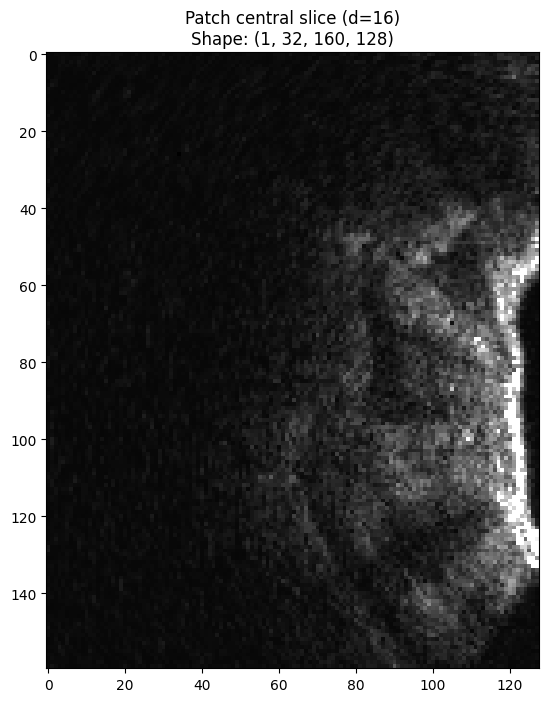

Type 'a' or 'accept' to visualize stages and PCA->RGB for this patch, or enter a new offset to preview another patch.
Capturing activations and visualizing stages + PCA->RGB (channels_per_stage= 3 )
Capturing activations and visualizing stages + PCA->RGB (channels_per_stage= 3 )


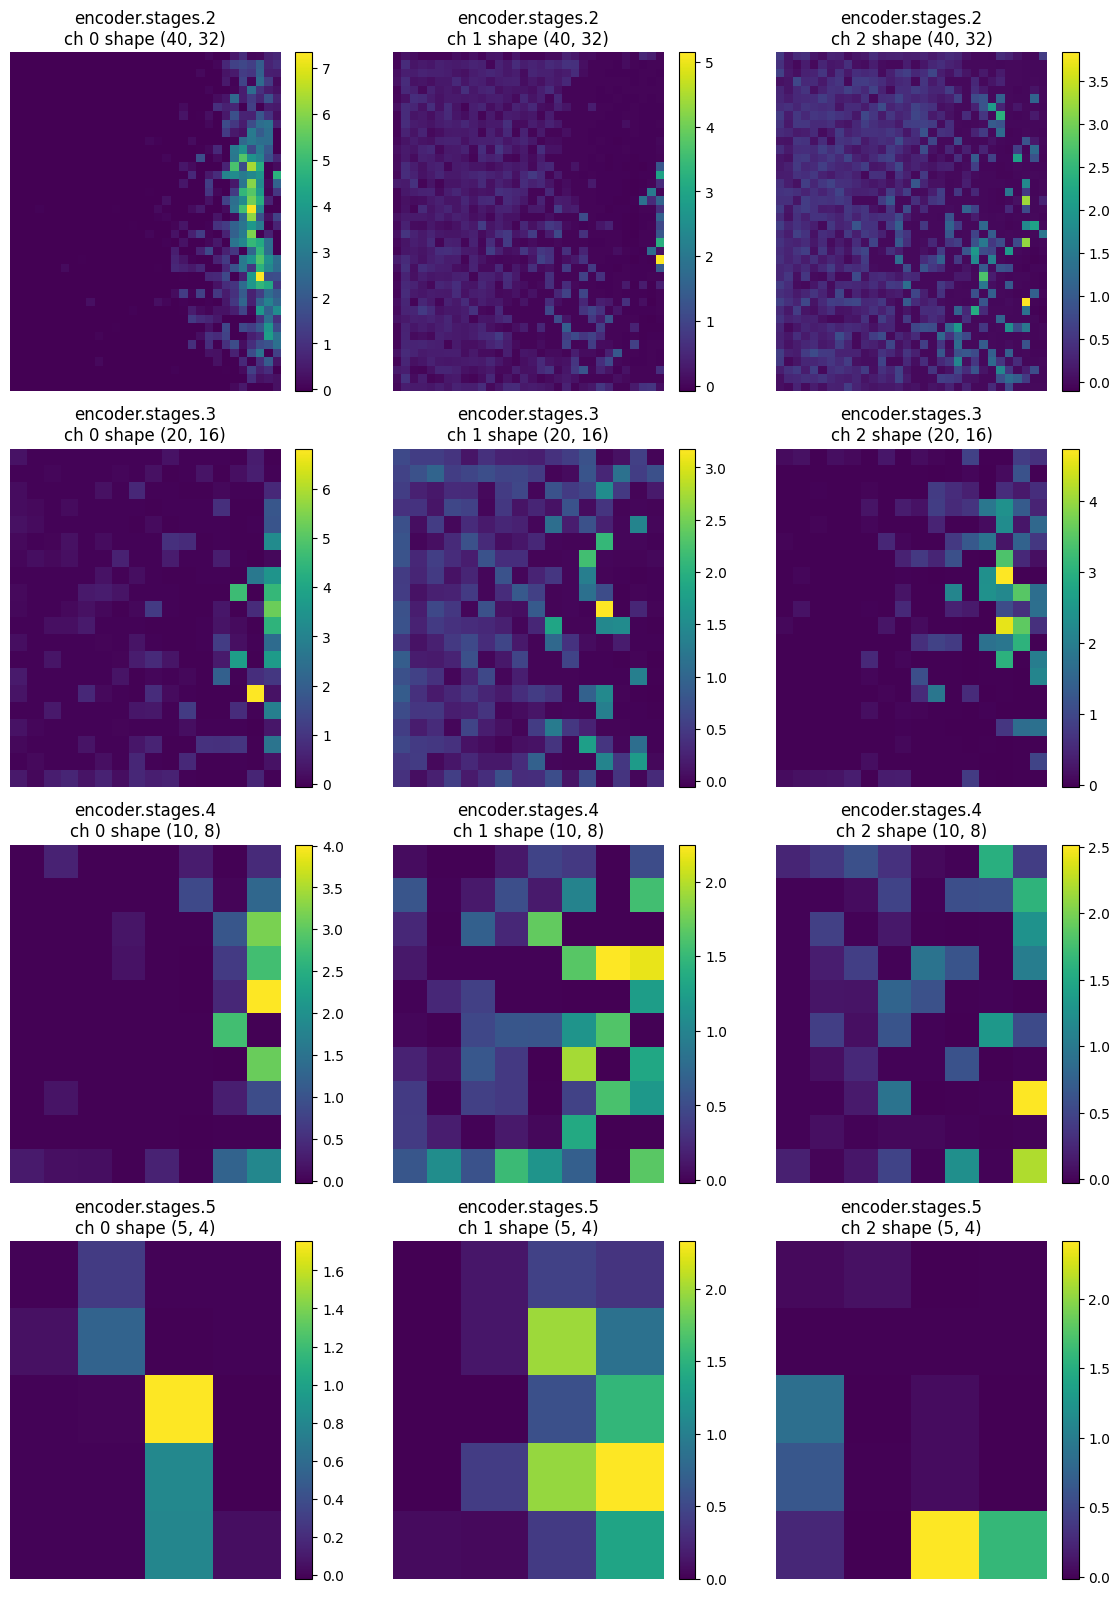


Computing PCA->RGB for encoder.stages.2


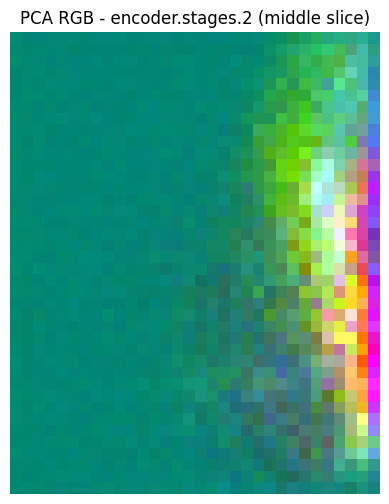


Computing PCA->RGB for encoder.stages.3


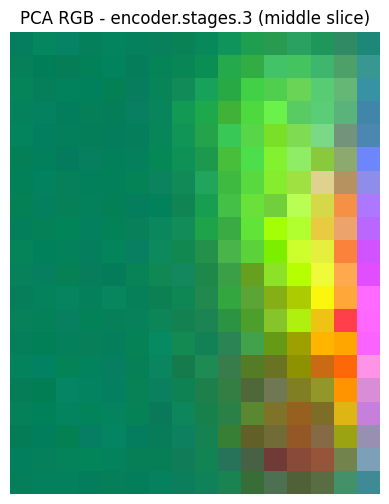


Computing PCA->RGB for encoder.stages.4


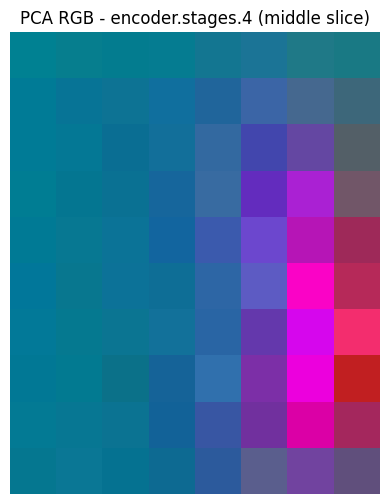


Computing PCA->RGB for encoder.stages.5


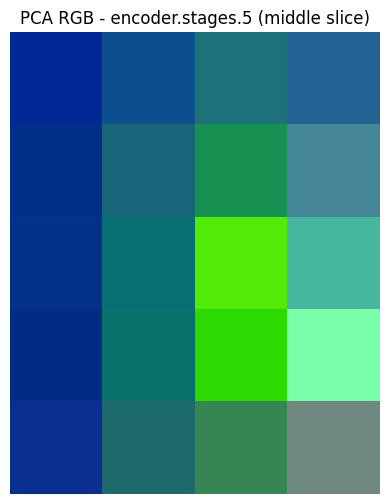

Exiting interactive visualizer


In [14]:
# Integrated interactive patch selector + multi-stage visualizer with PCA->RGB per-stage
# This cell reuses the helpers in the notebook:
#   - get_img_array()
#   - extract_patch_from_array(a, offset, patch_size)
#   - visualize_patch(patch)
#   - capture_activations_multiple(predictor, input_tensor, module_names)
#   - visualize_activations_grid(activations, channels_per_stage)

from sklearn.decomposition import PCA

DEFAULT_PATCH_SIZE = (32, 160, 128)

print('Interactive multi-stage patch visualizer (with PCA->RGB per-stage)')
print('Commands:')
print("  - enter offsets as 'd,h,w' to preview a patch")
print("  - 'modules <comma-separated module names>' to set which modules to capture (e.g. modules encoder.stages.2,encoder.stages.3)")
print("  - 'channels N' to set number of channels per stage to display")
print("  - 'accept' or 'a' to run visualization on the current patch (shows grid + PCA-RGB per stage)")
print("  - 'quit' to exit")

# use defaults
PATCH_SIZE = DEFAULT_PATCH_SIZE
module_names = None
channels_per_stage = 3

arr = get_img_array()
print('Loaded image shape (C,D,H,W):', arr.shape)
C, D, H, W = arr.shape
default_offset = (max(0, (D - PATCH_SIZE[0]) // 2), max(0, (H - PATCH_SIZE[1]) // 2), max(0, (W - PATCH_SIZE[2]) // 2))
print('Default center offset:', default_offset)

last_patch = None
last_offset = default_offset


def activation_to_rgb(act: np.ndarray, n_components: int = 3) -> np.ndarray:
    """Convert activation tensor to RGB image using PCA across channels.
    act: numpy array with shape [B, C, D, H, W] or [B, C, H, W]
    Returns: RGB image as numpy array with shape (H, W, 3) for 2D activations or (D, H, W, 3) for 3D.
    We return the full 3D/2D volume reduced to 3 channels; caller can pick a slice to display.
    """
    # take first batch
    a = act[0]
    # a shape: (C, D, H, W) or (C, H, W)
    if a.ndim == 4:
        C, D, H, W = a.shape
        spatial = (D, H, W)
        flat = a.reshape(C, -1).T  # (N, C)
        # run PCA on CPU
        p = PCA(n_components=n_components)
        comps = p.fit_transform(flat)  # (N, 3)
        comps = comps.reshape(D, H, W, n_components)
        # normalize per-channel to 0-1
        comps_norm = np.zeros_like(comps)
        for i in range(n_components):
            ch = comps[..., i]
            # clip percentiles to avoid outliers
            lo, hi = np.percentile(ch, (1, 99))
            ch = np.clip((ch - lo) / (hi - lo + 1e-12), 0.0, 1.0)
            comps_norm[..., i] = ch
        return comps_norm  # (D, H, W, 3)
    elif a.ndim == 3:
        C, H, W = a.shape
        flat = a.reshape(C, -1).T
        p = PCA(n_components=n_components)
        comps = p.fit_transform(flat)
        comps = comps.reshape(H, W, n_components)
        comps_norm = np.zeros_like(comps)
        for i in range(n_components):
            ch = comps[..., i]
            lo, hi = np.percentile(ch, (1, 99))
            ch = np.clip((ch - lo) / (hi - lo + 1e-12), 0.0, 1.0)
            comps_norm[..., i] = ch
        return comps_norm  # (H, W, 3)
    else:
        raise RuntimeError('Unsupported activation rank: ' + str(a.shape))


while True:
    s = input("offset/modules/channels/accept/quit > ").strip()
    if not s:
        continue
    if s.lower() == 'quit':
        print('Exiting interactive visualizer')
        break
    if s.lower().startswith('modules '):
        val = s[len('modules '):].strip()
        if val.lower() == 'default' or val == '':
            module_names = None
            print('Using default module list')
        else:
            module_names = [m.strip() for m in val.split(',') if m.strip()]
            print('Set module_names =', module_names)
        continue
    if s.lower().startswith('channels '):
        try:
            channels_per_stage = int(s.split()[1])
            print('Set channels_per_stage =', channels_per_stage)
        except Exception as e:
            print('Could not parse channels count:', e)
        continue
    if s.lower() in ('accept','a'):
        if last_patch is None:
            print('No patch selected yet. Enter an offset first.')
            continue
        print('Capturing activations and visualizing stages + PCA->RGB (channels_per_stage=', channels_per_stage,')')
        try:
            # prepare tensor
            x = last_patch
            if x.ndim == 4:
                x_in = np.expand_dims(x, 0)
            else:
                x_in = x
            input_tensor = torch.from_numpy(x_in).float()
            # capture multiple activations (they are moved to CPU inside)
            if module_names is None:
                module_names = default_stage_names_for(predictor.network, max_stages=4)
            activations, _ = capture_activations_multiple(predictor, input_tensor, module_names)

            # visualize grid (channels)
            visualize_activations_grid(activations, channels_per_stage=channels_per_stage)

            # For each activation compute PCA->RGB and display middle slice as RGB
            for name, act in activations.items():
                print('\nComputing PCA->RGB for', name)
                try:
                    rgb_vol = activation_to_rgb(act, n_components=3)
                except Exception as e:
                    print('PCA->RGB failed for', name, ':', e)
                    continue
                # rgb_vol: (D,H,W,3) or (H,W,3)
                if rgb_vol.ndim == 4:
                    mid = rgb_vol.shape[0] // 2
                    rgb_im = rgb_vol[mid]
                else:
                    rgb_im = rgb_vol
                # ensure float in 0-1
                rgb_im = np.clip(rgb_im, 0.0, 1.0)
                plt.figure(figsize=(6,6))
                plt.imshow(rgb_im)
                plt.title(f'PCA RGB - {name} (middle slice)')
                plt.axis('off')
                plt.show()
        except Exception as e:
            print('Visualization failed:', e)
        continue

    # parse potential offset input
    try:
        parts = [int(x) for x in s.split(',')]
        if len(parts) == 3:
            offs = tuple(parts)
        else:
            print("Provide offsets as 'd,h,w' or use commands. Got:", s)
            continue
    except Exception:
        print("Unknown command or bad offset. Use 'modules', 'channels', 'accept', or 'quit'.")
        continue

    patch, actual_offset = extract_patch_from_array(arr, offs, PATCH_SIZE)
    last_patch = patch.astype(np.float32)
    last_offset = actual_offset
    print('Extracted patch at offset (clamped):', actual_offset, 'patch shape:', patch.shape)
    visualize_patch(patch)
    print("Type 'a' or 'accept' to visualize stages and PCA->RGB for this patch, or enter a new offset to preview another patch.")